In [1]:
import os, json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import math

sns.set_theme()

order = ["PO-UCT: 10", "PO-UCT: 100", "PO-UCT: 1000", "PO-UCT: 5000", "Ours"]

In [2]:
# Load PO-UCT results
data_path = "./data/simulation_results/pouct_eval/"
file_names = [f for f in os.listdir(data_path) if f.endswith('.csv')]

data = []
for file_name in file_names:
    data.append(pd.read_csv(data_path+file_name))


pouct_data = pd.concat(data)
pouct_data["type"] = "PO-UCT: " + pouct_data["steps"].astype(str)
pouct_data.head()


,Unnamed: 0,reward,actions,seed,runtime,true_reward,expected_reward,steps,exploration_coeff,rollout_depth,type
0,0,3.732784,5,5000,1.707762,4.035003,3.732784,1000,10.0,0,PO-UCT: 1000
1,1,3.642689,5,5001,1.815193,4.204752,3.642689,1000,10.0,0,PO-UCT: 1000
2,2,3.707361,5,5002,1.933776,4.891583,3.707361,1000,10.0,0,PO-UCT: 1000
3,3,3.758194,5,5003,2.119002,5.131884,3.758194,1000,10.0,0,PO-UCT: 1000
4,4,3.922327,5,5004,2.121899,4.297647,3.922327,1000,10.0,0,PO-UCT: 1000


In [3]:
project_data = pd.read_csv("./data/simulation_results/eval_voc.csv")
project_data["type"] = "Ours"
project_data.head()

,Unnamed: 0,reward,actions,seed,runtime,true_reward,expected_reward,type
0,0,3.821586,3,5000,0.765625,4.039003,3.821586,Ours
1,1,3.819586,4,5001,0.890625,3.173295,3.819586,Ours
2,2,3.716219,5,5002,0.875000,4.638325,3.716219,Ours
3,3,3.821586,3,5003,0.718750,5.135884,3.821586,Ours
4,4,3.658340,5,5004,0.890625,4.297647,3.658340,Ours


In [9]:
merge_col = ["type", "expected_reward", "true_reward", "actions", "runtime", "seed"]
temp1 = project_data[merge_col]
temp2 = pouct_data[merge_col]

df = pd.concat([temp1, temp2])
df.dtypes


type                object
expected_reward    float64
true_reward        float64
actions              int64
runtime            float64
seed                 int64
dtype: object

Text(0.5, 0, '')

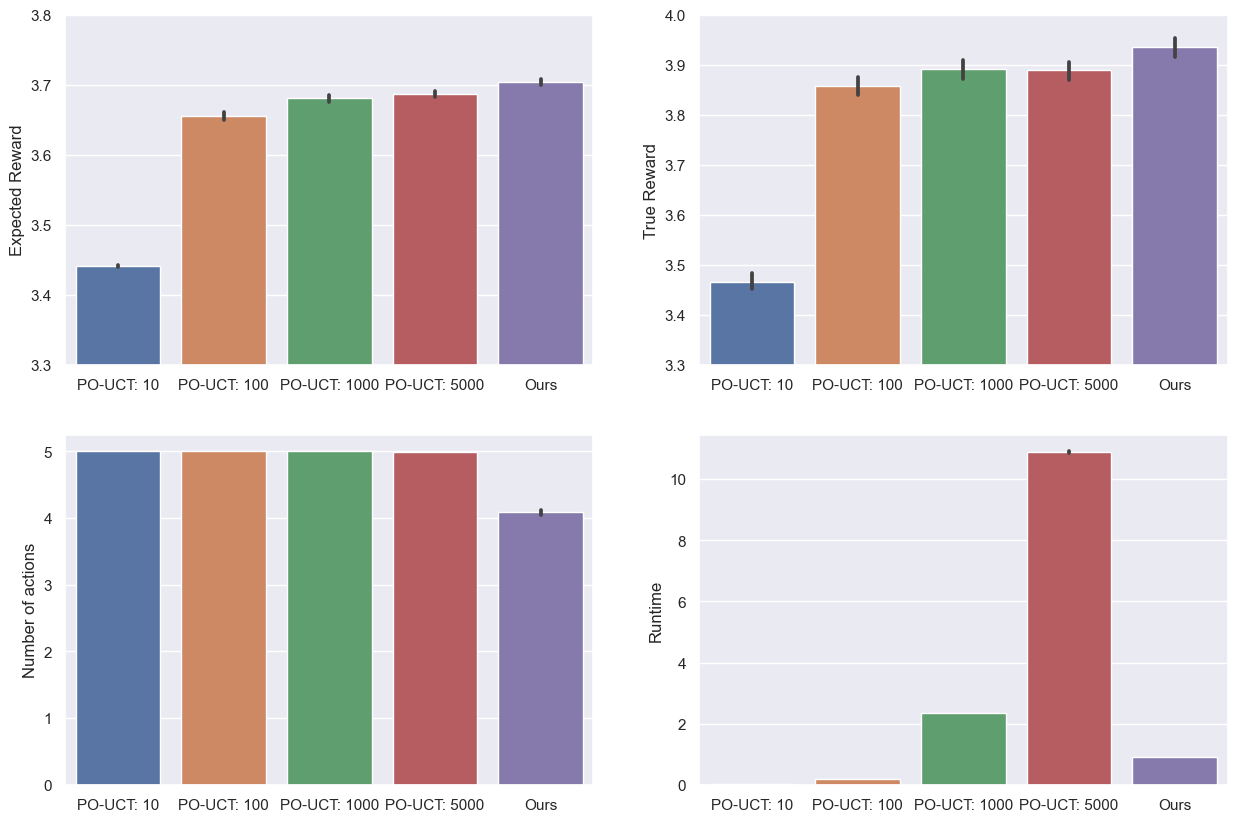

In [10]:
order = ["PO-UCT: 10", "PO-UCT: 100", "PO-UCT: 1000", "PO-UCT: 5000", "Ours"]

fig, axes =plt.subplots(2,2, figsize=(15,10))
axes = axes.flatten()

g = sns.barplot(df, y="expected_reward", x="type", ax=axes[0], order=order)
g.set_ylim((3.3, 3.8))
g.set_ylabel("Expected Reward")
g.set_xlabel("")
g = sns.barplot(df, y="true_reward", x="type", ax=axes[1], order=order)
g.set_ylim((3.3, 4))
g.set_ylabel("True Reward")
g.set_xlabel("")
g = sns.barplot(df, y="actions", x="type", ax=axes[2], order=order)
g.set_ylabel("Number of actions")
g.set_xlabel("")
g = sns.barplot(df, y="runtime", x="type", ax=axes[3], order=order)
g.set_ylabel("Runtime")
g.set_xlabel("")

In [7]:
#df.to_csv("./data/simulation_results/simulation_data.csv")

In [2]:
df = pd.read_csv("./data/simulation_results/simulation_data.csv")

In [3]:
df.columns

Index(['Unnamed: 0', 'type', 'expected_reward', 'true_reward', 'actions',
       'runtime'],
      dtype='object')

In [4]:
baseline_df = pd.read_csv("./data/simulation_results/random_baseline.csv")
mean = baseline_df["reward"].mean()
std = df["expected_reward"].std()
df["normalized_reward"] = (df["expected_reward"] - mean) / std
print(df["normalized_reward"].agg(["mean", "std"]))

mean    0.61283
std     1.00000
Name: normalized_reward, dtype: float64


Text(0.5, 1.0, 'Z-scored expected reward')

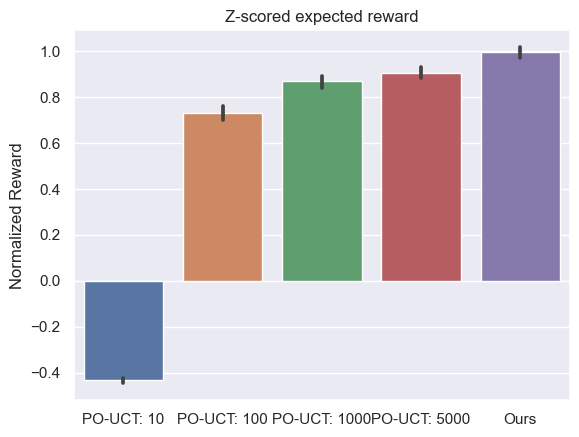

In [5]:
g = sns.barplot(df, y="normalized_reward", x="type", order=order)
g.set_ylabel("Normalized Reward")
g.set_xlabel("")
g.set_title("Z-scored expected reward")

In [6]:
df.groupby("type").agg(["mean", "std"])[["expected_reward", "normalized_reward", "runtime"]].round(4)

expected_reward         normalized_reward          runtime  \
                        mean     std              mean     std     mean   
type                                                                      
Ours                  3.7037  0.1550            0.9942  0.8433   0.9079   
PO-UCT: 10            3.4411  0.0703           -0.4344  0.3823   0.0175   
PO-UCT: 100           3.6553  0.2001            0.7309  1.0891   0.1972   
PO-UCT: 1000          3.6805  0.1697            0.8681  0.9233   2.3567   
PO-UCT: 5000          3.6873  0.1535            0.9054  0.8354  10.8913   

                      
                 std  
type                  
Ours          0.1886  
PO-UCT: 10    0.0135  
PO-UCT: 100   0.0285  
PO-UCT: 1000  0.1013  
PO-UCT: 5000  0.6240

In [7]:
def ci(column):
    stats = df.groupby("type").agg(["mean", "count", "std"])[column]
    ci95 = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95.append(1.96*s/math.sqrt(c))
    
    stats['ci95'] = ci95
    return stats.round(4)

ci("normalized_reward")

,mean,count,std,ci95
type,,,,
Ours,0.9942,5000,0.8433,0.0234
PO-UCT: 10,-0.4344,5000,0.3823,0.0106
PO-UCT: 100,0.7309,5000,1.0891,0.0302
PO-UCT: 1000,0.8681,5000,0.9233,0.0256
PO-UCT: 5000,0.9054,5000,0.8354,0.0232


In [8]:
ci("runtime")

,mean,count,std,ci95
type,,,,
Ours,0.9079,5000,0.1886,0.0052
PO-UCT: 10,0.0175,5000,0.0135,0.0004
PO-UCT: 100,0.1972,5000,0.0285,0.0008
PO-UCT: 1000,2.3567,5000,0.1013,0.0028
PO-UCT: 5000,10.8913,5000,0.6240,0.0173


In [10]:
import numpy as np

def cohend(d1, d2):
    # https://machinelearningmastery.com/effect-size-measures-in-python/
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

ours = df[df["type"]=="Ours"]["expected_reward"]
po_10 = df[df["type"]=="PO-UCT: 10"]["expected_reward"]
po_100 = df[df["type"]=="PO-UCT: 100"]["expected_reward"]
po_1000 = df[df["type"]=="PO-UCT: 1000"]["expected_reward"]
po_5000 = df[df["type"]=="PO-UCT: 5000"]["expected_reward"]

print("Cohen's d between ours and 10 step:", cohend(ours, po_10))
print("Cohen's d between ours and 100 step:", cohend(ours, po_100))
print("Cohen's d between ours and 1000 step:", cohend(ours, po_1000))
print("Cohen's d between ours and 5000 step:", cohend(ours, po_5000))

Cohen's d between ours and 10 step: 2.181971302312702
Cohen's d between ours and 100 step: 0.27028310530293115
Cohen's d between ours and 1000 step: 0.14255795034112073
Cohen's d between ours and 5000 step: 0.10575920004576697
